In [35]:
# set path
import os
import sys
my_path = os.path.abspath(os.path.dirname('.'))
path = os.path.join(my_path, "..")
sys.path.insert(1, path)

In [4]:
# load modules
import pandas as pd
from extract import extracted_data_analyzer as eda, aact_querier as aq
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import psycopg2
import getpass
import pandas.io.sql as psql
import plotly.express as px
import imageio
import pycountry as pc
from plotly.offline import iplot
from matplotlib.pyplot import *

In [5]:
#configs
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [6]:
## Functions for data exploration and visualization

In [20]:
def ctgov_data_prep(df):
    # Rename and format columns
    if '#nct_id' in df.columns:
        df.rename(columns={'#nct_id':'nct_id'}, inplace=True)
        
    if 'start_date' in df.columns:
        df['start_datetime']=pd.to_datetime(df['start_date'], format='%Y-%m-%d')
        df['start_year'] = df['start_datetime'].dt.to_period('Y')

In [21]:
def annual_stacked_bar(og_df, colname=None, collabel=None, start_year=2000, end_year=2021, style='white', palette='muted', colors=10, reverse=False):
    # set the figure size
    df=og_df.copy()
    plt.figure()
    sns.set(rc={'figure.figsize':(16.18,10)})
    sns.set(style=style)
    seapal=sns.color_palette(palette = palette, n_colors = colors, desat = None)
    sns.set_palette(seapal)
    
    #create stacked bar chart
    if colname is None:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year"])['nct_id'].nunique()        
        filepath="./visuals/stacked_bar_aggregate.png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)
        plt.title('Trials by Year', fontsize=16)        
    else:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year",colname])['nct_id'].nunique().unstack(colname).fillna(0)
        filepath="./visuals/stacked_bar_"+colname+".png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)
        
        title="Trials by "+colname
        if collabel is not None:
            title="Trials by "+collabel
            
        plt.title(title, fontsize=16)
        
    



    #add axis titles
    plt.xlabel('Trial Start Year')
    plt.ylabel('Number of Trials')
    
    plt.legend(bbox_to_anchor=(1.2,0.5) , loc='center right') 
    
    
    
    plt.savefig(filepath, bbox_inches='tight')
    return pivot.reset_index()

    #rotate x-axis labels
    # plt.xticks(rotation=45)

In [33]:
def annual_stacked_bar_100(og_df, colname=None, collabel=None, start_year=2000, end_year=2021, style='white', palette='muted', colors=10, reverse=False):
    # set the figure size
    df=og_df.copy()
    plt.figure()
    sns.set(rc={'figure.figsize':(16.18,10)})
    sns.set(style=style)
    seapal=sns.color_palette(palette = palette, n_colors = colors, desat = None)
    sns.set_palette(seapal)
    
    #create stacked bar chart
    if colname is None:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year"])['nct_id'].nunique()       
        filepath="./visuals/stacked_bar_100_aggregate.png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)
        plt.title('Trials by Year', fontsize=16)
        
        #add axis titles
        plt.xlabel('Trial Start Year')
        plt.ylabel('Proportion of Trials')
        plt.legend(bbox_to_anchor=(1.2,0.5) , loc='center right') 
        plt.savefig(filepath, bbox_inches='tight')

    else:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year"])[colname].value_counts(normalize=True).unstack(colname).fillna(0)
        filepath="./visuals/stacked_bar_100_"+colname+".png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)

        title="Trials by "+colname
        if collabel is not None:
            title="Trials by "+collabel
            
        plt.title(title, fontsize=16)
        #add axis titles
        plt.xlabel('Trial Start Year')
        plt.ylabel('Proportion of Trials')
        plt.legend(bbox_to_anchor=(1.2,0.5) , loc='center right') 
        plt.savefig(filepath, bbox_inches='tight')
        plt.show()
        
        pie_title="2021 Trials by "+colname
        if collabel is not None:
            pie_title="2021 Trials by "+collabel
        
        if reverse:
            plt.pie(pivot.sort_index(axis=1, ascending=False).reset_index()[pivot.sort_index(axis=1, ascending=False).reset_index().start_year.dt.year==end_year].iloc[0, 1:].tolist(), labels = pivot.sort_index(axis=1, ascending=False).reset_index()[pivot.sort_index(axis=1, ascending=False).reset_index().start_year.dt.year==end_year].columns[1:].tolist(), autopct='%.0f%%')
        else:
            plt.pie(pivot.reset_index()[pivot.reset_index().start_year.dt.year==end_year].iloc[0, 1:].tolist(), labels = pivot.reset_index()[pivot.reset_index().start_year.dt.year==end_year].columns[1:].tolist(), autopct='%.0f%%')
        
        
        plt.title(pie_title, fontsize=16)
        pie_path="./visuals/stacked_pie_100_"+colname+".png"
        plt.savefig(pie_path, bbox_inches='tight')
        plt.show()
        
    



    
    
    
    return pivot.reset_index()

    #rotate x-axis labels
    # plt.xticks(rotation=45)

In [10]:
## Explore cancer trials

In [11]:
path

'/Users/forrest.xiao/non_fh_code/trialtracker/analysis/..'

In [12]:
# All cancer trials
onc_trials=pd.read_csv(path+"/extract/extracted_data/ct_fb_parser_data.csv", index_col=0)

In [13]:
onc_trials.head()

,#nct_id,title,has_us_facility,conditions,eligibility_criteria,start_date,lead_sponsor,summary,overall_status,phase,enrollment,enrollment_type,study_type,number_of_arms,number_of_groups,why_stopped,has_dmc,is_fda_regulated_drug,is_fda_regulated_device,is_unapproved_device,is_ppsd,is_us_export
0,NCT00000105,Vaccination With Tetanus and KLH to Assess Imm...,True,Cancer,Inclusion Criteria:\n\nPatients must have a di...,2002-07-31,"Masonic Cancer Center, University of Minnesota",The purpose of this study is to learn how the ...,Terminated,NaN,112.0,Actual,Observational,NaN,3.0,Replaced by another study.,True,NaN,NaN,NaN,NaN,NaN
1,NCT00000124,Collaborative Ocular Melanoma Study (COMS),False,Choroid Neoplasms|Uveitis,Men and women eligible for the study must be a...,1986-11-30,National Eye Institute (NEI),To evaluate therapeutic interventions for pati...,Unknown status,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NCT00000603,Cord Blood Stem Cell Transplantation Study (CO...,False,"Anemia, Aplastic|Fanconi Anemia|Hematologic Di...",Mothers of Infant-donors must complete a medic...,1996-09-30,"National Heart, Lung, and Blood Institute (NHLBI)","To evaluate if HLA-mismatched, unrelated-donor...",Completed,Phase 2,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NCT00000611,Women's Health Initiative (WHI),False,Bone Diseases|Breast Neoplasms|Cardiovascular ...,Postmenopausal women ages 50 to 79.,NaN,"National Heart, Lung, and Blood Institute (NHLBI)","To address cardiovascular disease, cancer, and...",Completed,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NCT00000764,Chemoprevention of Anal Neoplasia Arising Seco...,True,Anus Neoplasms|HIV Infections,Inclusion Criteria\n\nConcurrent Medication:\n...,NaN,National Institute of Allergy and Infectious D...,"PRIMARY: In Phase I, to define a broadly toler...",Completed,Phase 1,98.0,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
ctgov_data_prep(onc_trials)

In [15]:
# Clean phase column
# onc_trials['phase'].fillna('Null', inplace=True)
phase_map={'Early Phase 1':'a) Early Phase 1',
           'Phase 1':'b) Phase 1',
           'Phase 1/Phase 2':'c) Phase 1/Phase 2',
           'Phase 2':'d) Phase 2',
           'Phase 2/Phase 3':'e) Phase 2/Phase 3',
           'Phase 3':'e) Phase 3',
           'Phase 4':'f) Phase 4',
           'Not Applicable':'g) Not Applicable'
          }

onc_trials['mapped_phase']=onc_trials['phase'].map(phase_map).fillna('h) Missing')

In [16]:
# Clean study column
# onc_trials['phase'].fillna('Null', inplace=True)
study_type_map={'Interventional':'a) Interventional',
           'Observational':'b) Observational',
           'Observational [Patient Registry]':'c) Observational [Patient Registry]',
           'Expanded Access':'d) Expanded Access',
          }

onc_trials['mapped_study_type']=onc_trials['study_type'].map(study_type_map).fillna('e) Missing')

In [17]:
#Summary stats and figures

In [18]:
onc_trial_count=onc_trials[(onc_trials.start_datetime.dt.year>=2000)&(onc_trials.start_datetime.dt.year<=2021)]['nct_id'].nunique()
print(f"{onc_trial_count} cancer trials from 2000 to 2021.")

50197 cancer trials from 2000 to 2021.


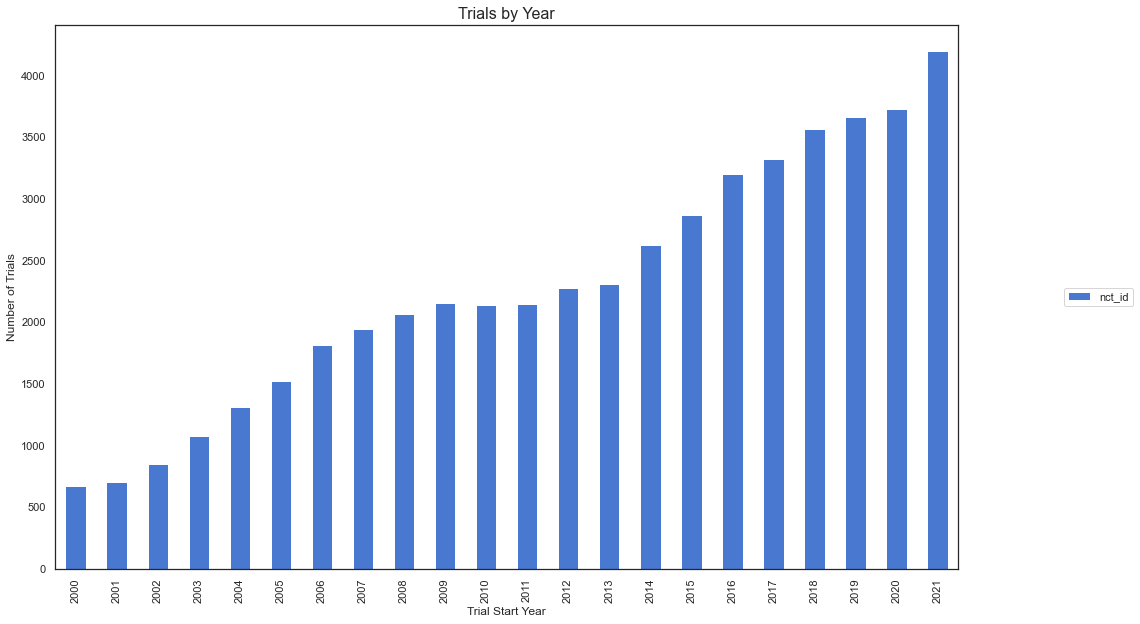

In [23]:
#Overall Trial Volume
df=annual_stacked_bar(onc_trials)

<Figure size 1164.96x720 with 0 Axes>

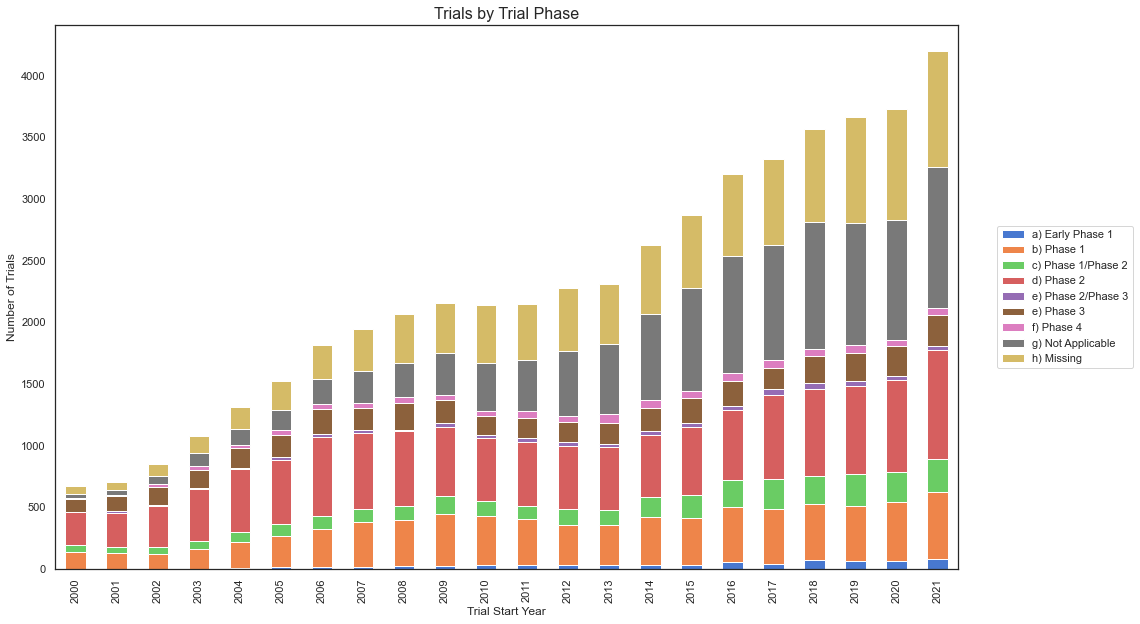

In [24]:
#Overall Trial Volume
df=annual_stacked_bar(onc_trials, colname='mapped_phase', collabel="Trial Phase")

<Figure size 1164.96x720 with 0 Axes>

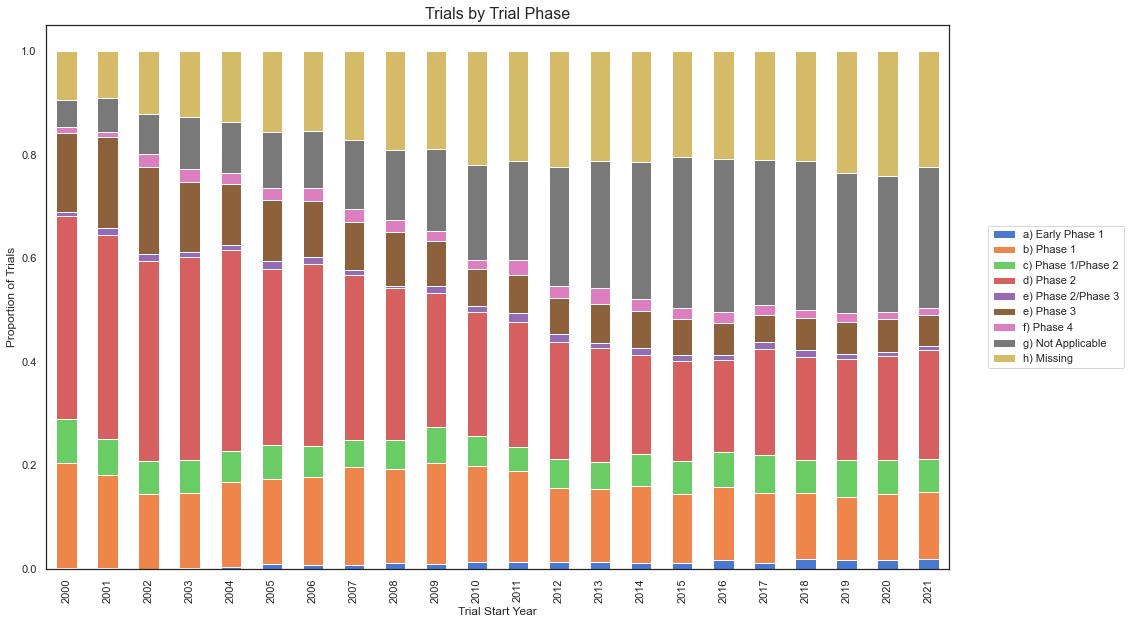

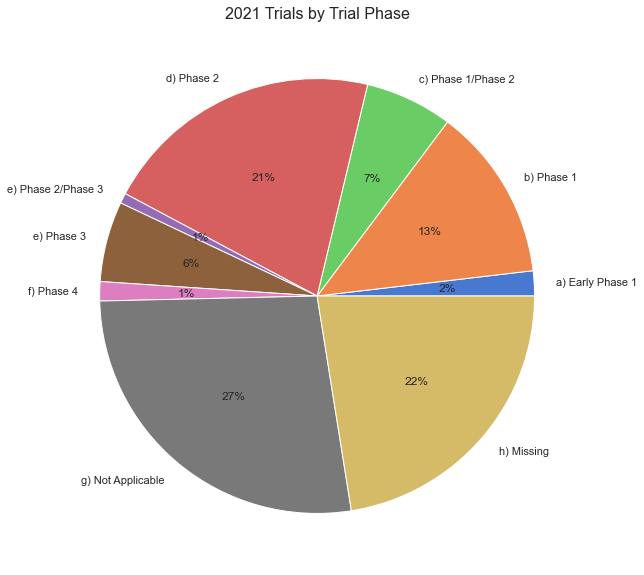

In [25]:
#Trials by Phase
df=annual_stacked_bar_100(onc_trials, colname='mapped_phase', collabel="Trial Phase")

<Figure size 1164.96x720 with 0 Axes>

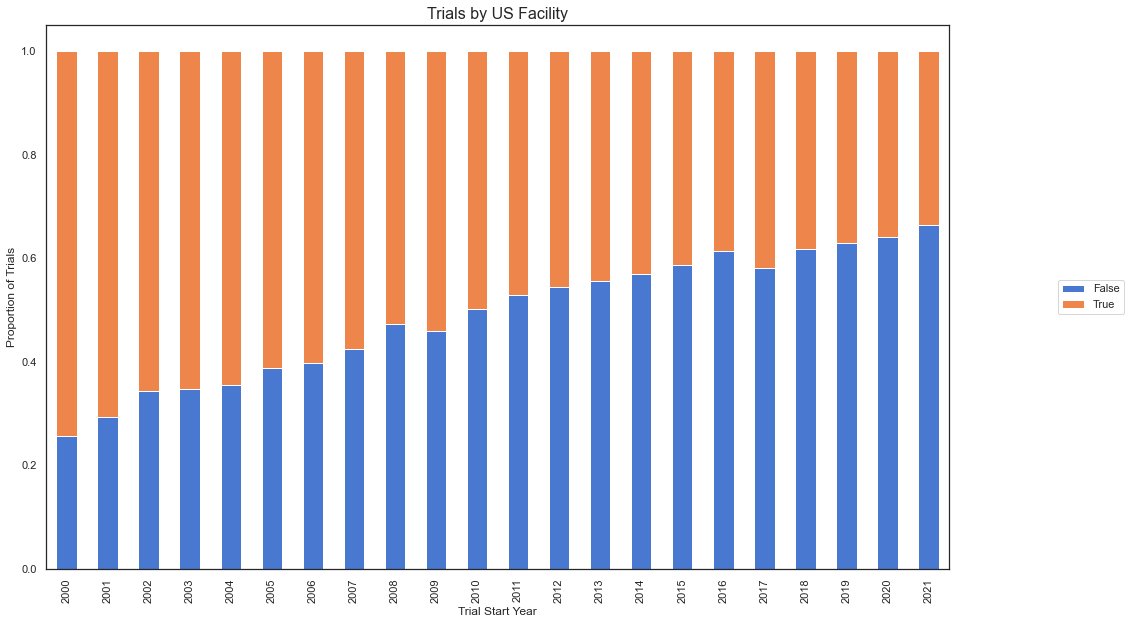

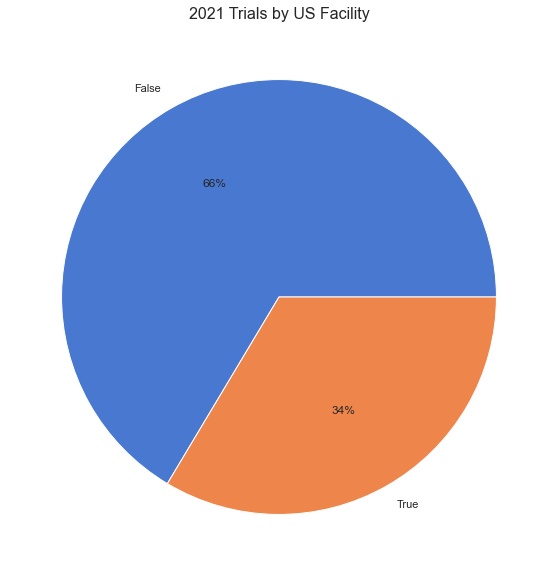

In [27]:
#Trials by Site
df=annual_stacked_bar_100(onc_trials, colname='has_us_facility', collabel="US Facility")

<Figure size 1164.96x720 with 0 Axes>

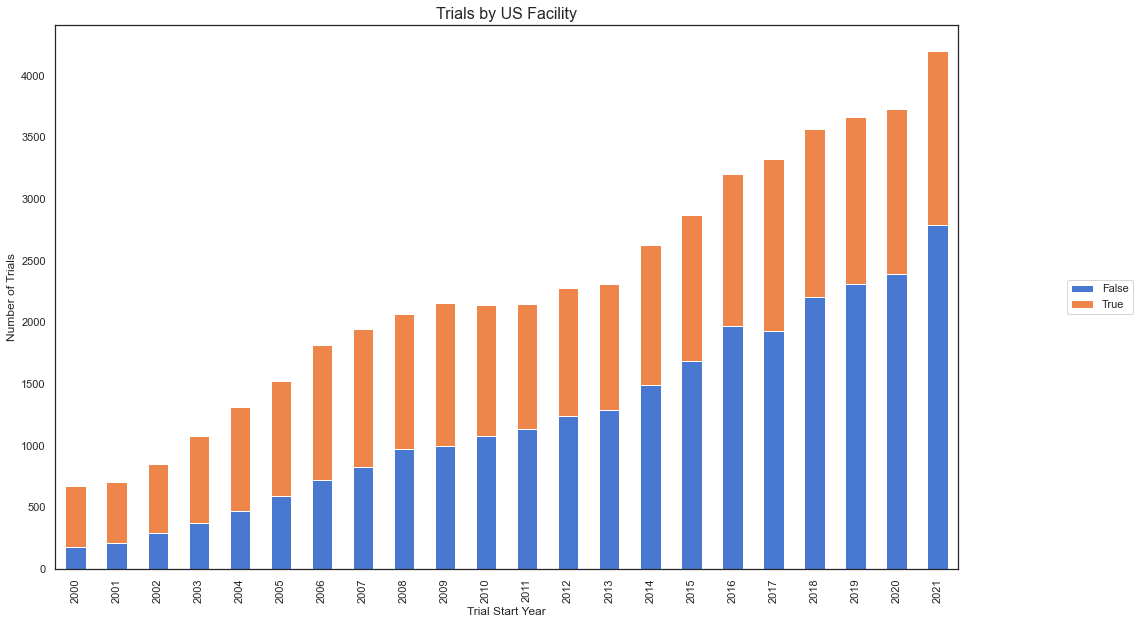

In [28]:
df=annual_stacked_bar(onc_trials, colname='has_us_facility', collabel="US Facility")

<Figure size 1164.96x720 with 0 Axes>

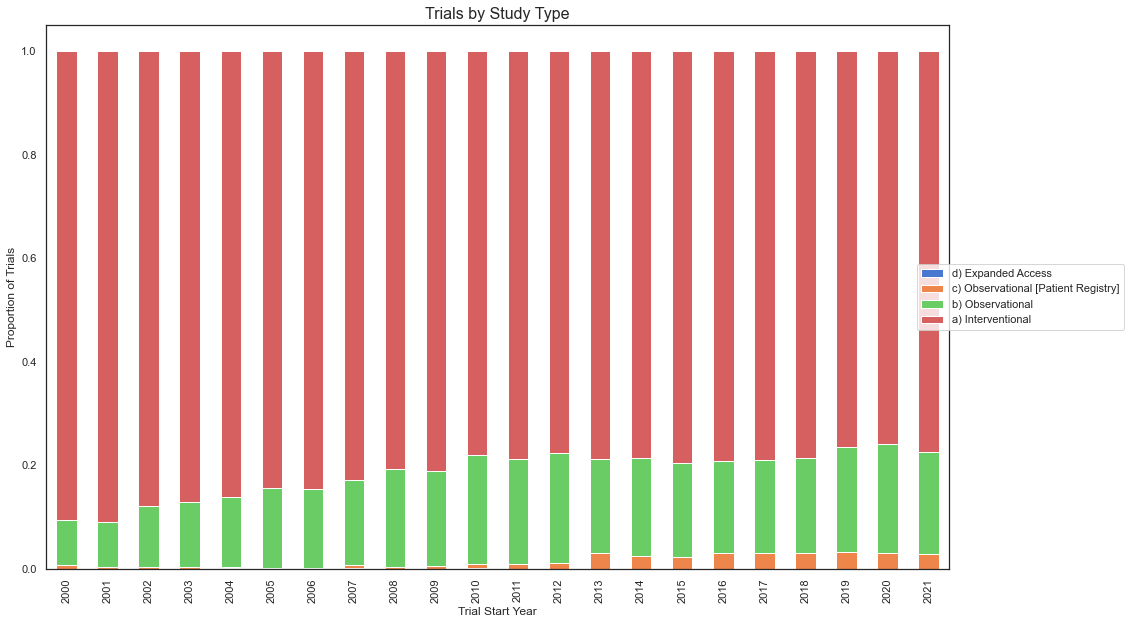

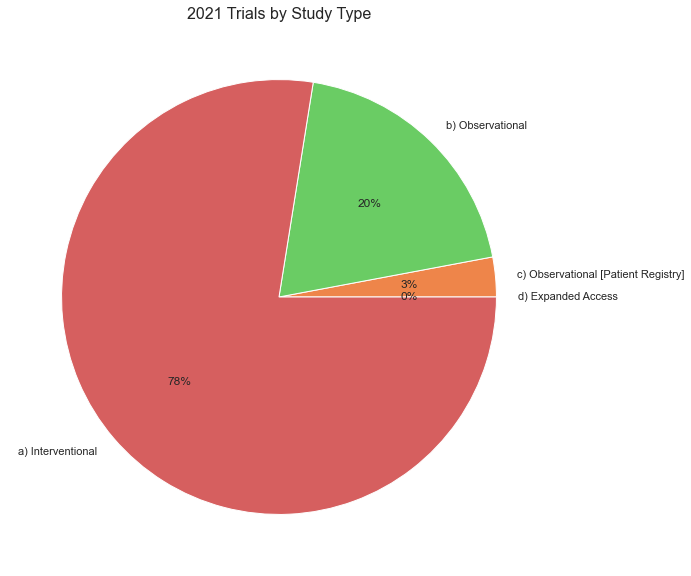

In [34]:
#Trials by Study Type
df=annual_stacked_bar_100(onc_trials, colname='mapped_study_type', collabel="Study Type", reverse=True)